In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models,utils
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import os 
import cv2 as cv
from IPython.display import clear_output
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
path = ''
image_path = os.path.join(path,'/content/drive/MyDrive/last/image')
mask_path = os.path.join(path , '/content/drive/MyDrive/last/mask')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list.sort()
mask_list.sort()
image_list = [ image_path+'/'+ i for i in image_list]
mask_list  =  [mask_path +'/'+ i for i in mask_list ]
len(image_list)

180

In [ ]:
# #print(os.listdir("membrane/train"))
# import glob
# import cv2
# #Resizing images is optional, CNNs are ok with large images
# SIZE_X = 128 #Resize images (height  = X, width = Y)
# SIZE_Y = 128

# #Capture training image info as a list
# train_images = []
# for directory_path in glob.glob(image_path):
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         #print(img_path)
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
#         img = cv2.resize(img, (SIZE_Y, SIZE_X))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         train_images.append(img)
#         #train_labels.append(label)
# #Convert list to array for machine learning processing        
# train_images = np.array(train_images)

# #Capture mask/label info as a list
# train_masks = [] 
# for directory_path in glob.glob('mask_path'):
#     for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
#         mask = cv2.imread(mask_path, 0)       
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
#         #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
#         train_masks.append(mask)
#         #train_labels.append(label)
# #Convert list to array for machine learning processing          
# train_masks = np.array(train_masks)


Text(0.5, 1.0, 'Segmentation/content/drive/MyDrive/last/mask/Mixed18_jpg.rf.977ed3e5e173062a6f2029e04ddc2c24_mask.png')

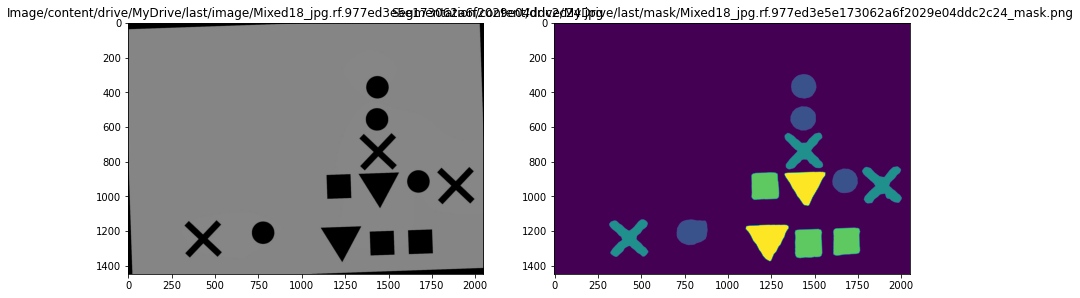

In [ ]:
import imageio
N = 20


img  =  imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)

arr[0].set_title('Image'+image_list[N])
arr[1].imshow(mask)
arr[1].set_title('Segmentation'+mask_list[N])

In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
  
    print(image)
    print(mask)


tf.Tensor(b'/content/drive/MyDrive/last/image/Mixed10_jpg.rf.32582d13239e48db78897fd154719299.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/last/mask/Mixed10_jpg.rf.32582d13239e48db78897fd154719299_mask.png', shape=(), dtype=string)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.5, 1.5),
])

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate


In [ ]:

def conv_block(inputs=None, n_filters=32, dropout_prob=0.2, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [ ]:

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=5):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    data_augmentation
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],   n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],   n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],   n_filters )
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:

img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 96, 128, 32)  896         ['input_3[0][0]']                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_40[0][0]']              
                                                                                                  
 dropout_10 (Dropout)           (None, 96, 128, 32)  0           ['conv2d_41[0][0]']        

In [ ]:
# def dice_coeff(y_true, y_pred):
#     smooth = 1.
#     # Flatten
#     y_true = tf.keras.backend.flatten(y_true)
#     y_pred = tf.keras.backend.flatten(y_pred)
#     y_true_f = tf.cast(y_true, tf.float32)
#     y_pred_f = tf.cast(y_pred, tf.float32)
#     intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
#     union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
#     score = (2. * intersection + smooth) / (union + smooth)
#     return score
# def dice_loss(y_true, y_pred):
#   loss = 1 - dice_coeff(y_true, y_pred)
#   return loss


In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
unet.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# for image, mask in image_ds.take(5):
#     sample_image, sample_mask = image, mask
#     print(mask.shape)
# display([sample_image, sample_mask])


In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


[<tf.Tensor: shape=(96, 128, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], d

In [ ]:
# !pip install segmentation_models

In [ ]:
# !pip install tensorflow_addons

In [ ]:
# import glob
# import cv2
# import os
# import numpy as np
# from matplotlib import pyplot as plt
# import tensorflow as tf
# #import tensorflow_addons as tfa
# #import segmentation_models as sm
# import tensorflow_addons as tfa

# import glob
# BACKBONE = 'resnet34'
# #preprocess_input = sm.get_preprocessing(BACKBONE)

# #Use customary x_train and y_train variables
# X = train_images
# Y = train_masks
# Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# # preprocess input



In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
6/6 [==============================] - 8s 158ms/step - loss: 0.3543 - accuracy: 0.8733
Epoch 2/40
6/6 [==============================] - 1s 161ms/step - loss: 0.3473 - accuracy: 0.8752
Epoch 3/40
6/6 [==============================] - 1s 163ms/step - loss: 0.3423 - accuracy: 0.8766
Epoch 4/40
6/6 [==============================] - 1s 164ms/step - loss: 0.3387 - accuracy: 0.8780
Epoch 5/40
6/6 [==============================] - 1s 164ms/step - loss: 0.3299 - accuracy: 0.8813
Epoch 6/40
6/6 [==============================] - 1s 163ms/step - loss: 0.3256 - accuracy: 0.8822
Epoch 7/40
6/6 [==============================] - 1s 165ms/step - loss: 0.3187 - accuracy: 0.8851
Epoch 8/40
6/6 [==============================] - 1s 164ms/step - loss: 0.3294 - accuracy: 0.8838
Epoch 9/40
6/6 [==============================] - 1s 165ms/step - loss: 0.3189 - accuracy: 0.88

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

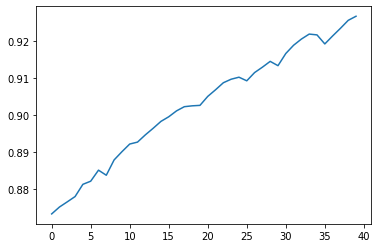

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
import numpy as np

def show_predictions(dataset=None, num=1):
  if dataset is not None:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)mM
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
      ax1.imshow(np.squeeze(image[0]))
      ax2.imshow(np.squeeze(mask[0]))
      ax3.imshow(np.squeeze(create_mask(pred_mask)))
      plt.show()
  else:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.imshow(np.squeeze(sample_image))
    ax2.imshow(np.squeeze(sample_mask))
    ax3.imshow(np.squeeze(create_mask(unet.predict(sample_image[tf.newaxis, ...]))))
    plt.show()
    return unet.predict(sample_image[tf.newaxis, ...])


1/1 [==============================] - 0s 24ms/step


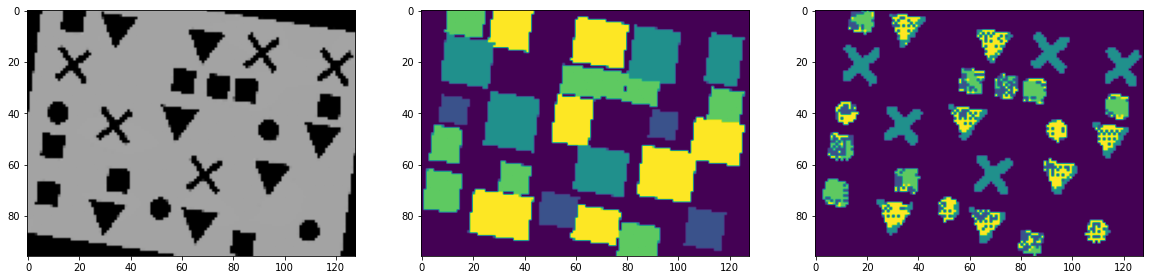

1/1 [==============================] - 0s 25ms/step


In [ ]:
segmented_image=show_predictions()

1/1 [==============================] - 0s 23ms/step


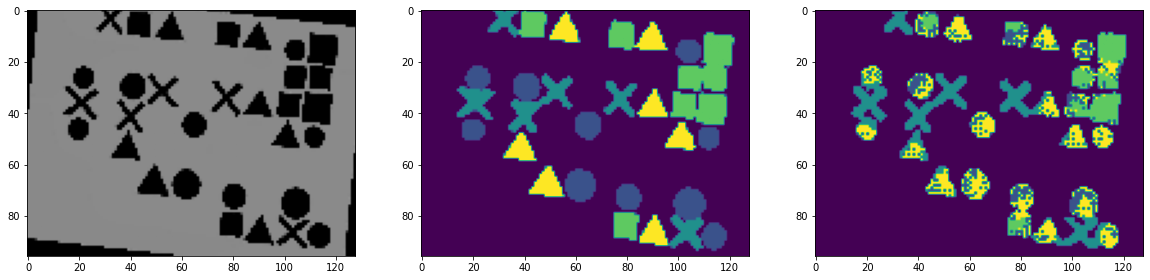

1/1 [==============================] - 0s 29ms/step


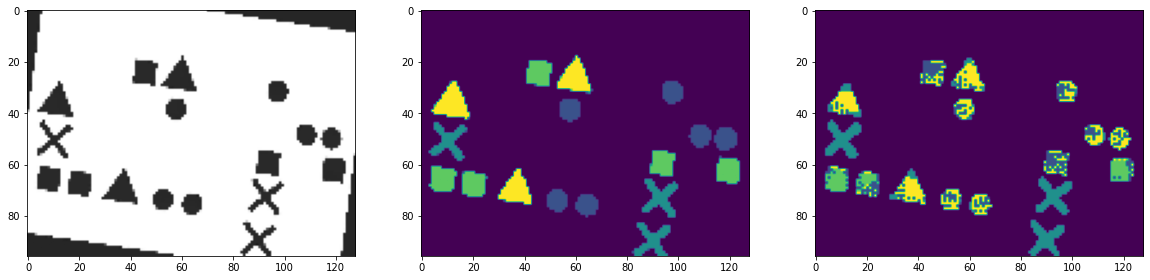

1/1 [==============================] - 0s 24ms/step


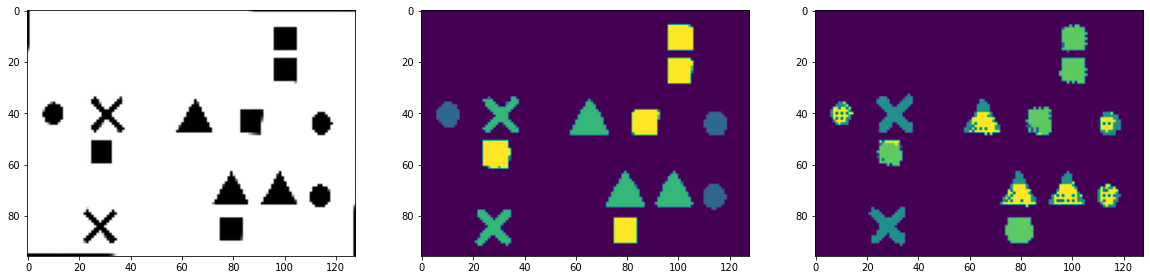

1/1 [==============================] - 0s 26ms/step


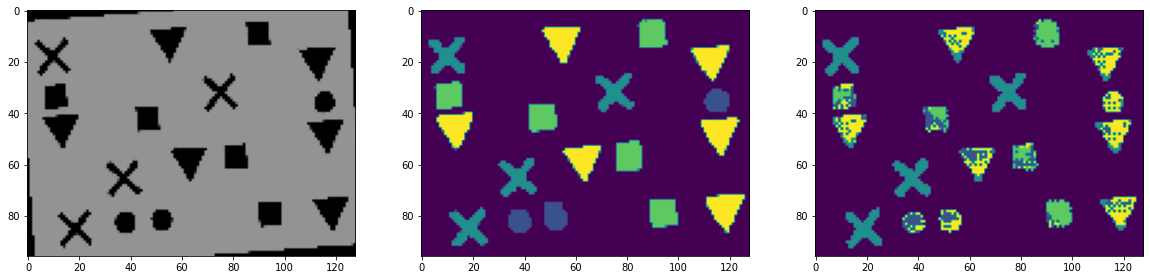

1/1 [==============================] - 0s 24ms/step


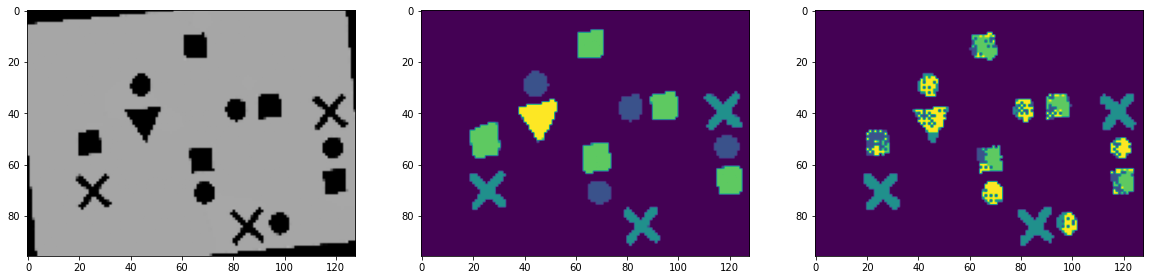

1/1 [==============================] - 0s 24ms/step


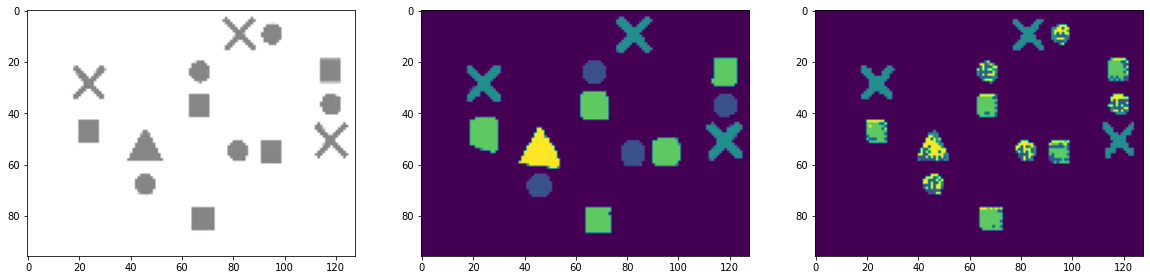

In [ ]:
show_predictions(train_dataset, 10)

1/1 [==============================] - 0s 24ms/step


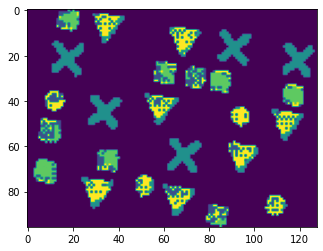

In [ ]:
s = np.squeeze(create_mask(unet.predict(sample_image[tf.newaxis, ...])))
plt.imshow(s)

(96, 128)
(96, 128)
Number of circles found = 25


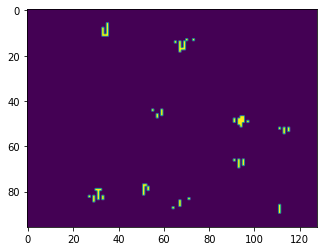

In [ ]:
import cv2
import numpy as np

# img = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
# _,h,w,c = segmented_image.shape
# c = segmented_image.reshape(h,w,c)
# print(c.shape)
img = s
print(s.shape)
# plt.imshow(np.squeeze(segmented_image))

# img = cv2.resize(img, (img.shape[1]//3, img.shape[0]//3), interpolation=cv2.INTER_CUBIC)
circle_class = np.uint8((img ==4) *255)
circle_class = cv2.erode(circle_class, (3,3), iterations=4)
plt.imshow(circle_class)

print(circle_class.shape)
circle_contours, _ = cv2.findContours(circle_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Number of circles found = " + str(len(circle_contours)))


# cross_class = np.uint8((img ==2) *255)
# cross_class = cv2.erode(cross_class, (3,3), iterations=5)
# cross_contours, _ = cv2.findContours(cross_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print("Number of crosses found = " + str(len(cross_contours)))


# square_class = np.uint8((img ==3) *255)
# square_class = cv2.erode(square_class, (3,3), iterations=5)
# square_contours, _ = cv2.findContours(square_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print("Number of squares found = " + str(len(square_contours)))


# triangle_class = np.uint8((img ==4) *255)
# triangle_class = cv2.erode(triangle_class, (3,3), iterations=5)
# triangle_contours, _ = cv2.findContours(triangle_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print("Number of triangles found = " + str(len(triangle_contours)))

# output_value = len(circle_contours)*20 + len(cross_contours)*5 + len(square_contours)*15 + len(triangle_contours)*10
# print("Output Value : " + str(output_value))

# plt.imshow( circle_class)
# plt.imshow( cross_class)
# plt.imshow( square_class)
# plt.imshow( triangle_class)



In [ ]:

# Split the image into its color channels
b, g, r = cv2.split(segmentation)

# Display the individual color channels
cv2.imshow("Blue", b)
cv2.imshow("Green", g)
cv2.imshow("Red", r)

# Wait for a key to be pressed
cv2.waitKey(0)

# Destroy all windows
cv2.destroyAllWindows()

NameError: ignored

In [ ]:
import cv2
import numpy as np

def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

def getContours(img):
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 1:
            cv2.drawContours(imgContour, cnt, -1, (255, 0, 0), 3)
            peri = cv2.arcLength(cnt,True)
            #print(peri)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            
            objCor = len(approx)
            x, y, w, h = cv2.boundingRect(approx)

            if objCor ==3:
                objectType ="Tri"
                print("Tri::",objCor);
            elif objCor == 4:
                aspRatio = w/float(h)
                if aspRatio >0.98 and aspRatio <1.03: objectType= "Square"
                else:objectType="Square"
                print("square::",objCor);
            elif objCor==12:
                objectType= "cross"
                print("Cross::",objCor);
            else:
                objectType="circle"
                print("circle::",objCor);



            cv2.rectangle(imgContour,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(imgContour,objectType,
                        (x+(w//2),y+(h//2)-10),cv2.FONT_HERSHEY_COMPLEX,0.7,
                        (0,0,0),2)




img = 
imgContour = img.copy()

imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray,(7,7),1)
imgCanny = cv2.Canny(imgBlur,50,50)
getContours(imgCanny)

imgBlank = np.zeros_like(img)
imgStack = stackImages(0.8,([img,imgGray,imgBlur],
                            [imgCanny,imgContour,imgBlank]))

cv2.imshow("Stack", imgStack)

cv2.waitKey(0)


IndexError: ignored